In [41]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = 8, 4

In [3]:
def get_mongo_database(db_name, host='localhost', port=27017,username = None, password = None):
    """get named database from MongoDB with/out authentication"""
    #Make Mong connection with/out authentication
    if username and password:
        mongo_uri ='mongodb://%s:%s@%s/%s' %(username, password, host, db_name)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host,port)
    return conn[db_name]

In [4]:
def mongo_to_dataframe(db_name, collection, query={},host='localhost', port=27017,\
                        username=None, password=None,no_id=True):
    """ create a dataframe from mongodb collection """
    db = get_mongo_database(db_name, host, port, username,\
                            password)
    cursor = db[collection].find(query)
    df = pd.DataFrame(list(cursor))
    if no_id:
        del df['_id']
    return df 

In [5]:
df = mongo_to_dataframe('nobel_prize', 'winners_cleaned')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852 entries, 0 to 1851
Data columns (total 12 columns):
award_age         1852 non-null int64
category          1852 non-null object
country           1852 non-null object
date_of_birth     1852 non-null object
date_of_death     1556 non-null object
gender            1852 non-null object
link              1852 non-null object
name              1852 non-null object
place_of_birth    1852 non-null object
place_of_death    1260 non-null object
text              1852 non-null object
year              1852 non-null int64
dtypes: int64(2), object(10)
memory usage: 173.7+ KB


In [7]:
# convert date_of_birth and death to datetime
df.date_of_birth = pd.to_datetime(df.date_of_birth)
df.date_of_death = pd.to_datetime(df.date_of_death)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852 entries, 0 to 1851
Data columns (total 12 columns):
award_age         1852 non-null int64
category          1852 non-null object
country           1852 non-null object
date_of_birth     1852 non-null datetime64[ns]
date_of_death     1260 non-null datetime64[ns]
gender            1852 non-null object
link              1852 non-null object
name              1852 non-null object
place_of_birth    1852 non-null object
place_of_death    1260 non-null object
text              1852 non-null object
year              1852 non-null int64
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 173.7+ KB


In [9]:
# Gender Disparities
by_cat_gen = df.groupby(['category','gender'])
by_cat_gen.get_group(('Physics', 'female'))[['name', 'year']]

,name,year
327,Maria Goeppert-Mayer,1963
553,Marie Skłodowska-Curie,1903
779,Donna Strickland,2018
1002,Maria Goeppert-Mayer,1963
1618,Donna Strickland,2018
1831,Marie Skłodowska-Curie,1903


In [10]:
# Using the size method to get the size of these groups returns a Series with a MultiIndex that labels the values by both category and gender:
by_cat_gen.size()

category                gender
Chemistry               female     10
                        male      358
Economics               female      4
                        male      164
Literature              female     30
                        male      198
Peace                   female     34
                        male      180
Physics                 female      6
                        male      424
Physiology or Medicine  female     24
                        male      420
dtype: int64

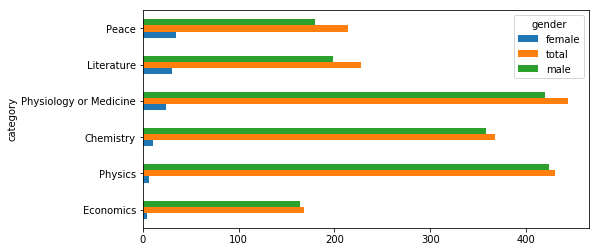

In [11]:
cat_gen_sz = by_cat_gen.size().unstack()
cat_gen_sz['total'] = cat_gen_sz.sum(axis=1)
cat_gen_sz = cat_gen_sz.sort_values(by='female', ascending=True)
cat_gen_sz[['female', 'total', 'male']].plot(kind='barh')

In [12]:
# Let’s remind the female prize winners is in Physics
df[(df.category == 'Physics') & (df.gender == 'female')][['name', 'country','year']]

,name,country,year
327,Maria Goeppert-Mayer,United States,1963
553,Marie Skłodowska-Curie,Poland,1903
779,Donna Strickland,Canada,2018
1002,Maria Goeppert-Mayer,United States,1963
1618,Donna Strickland,Canada,2018
1831,Marie Skłodowska-Curie,Poland,1903


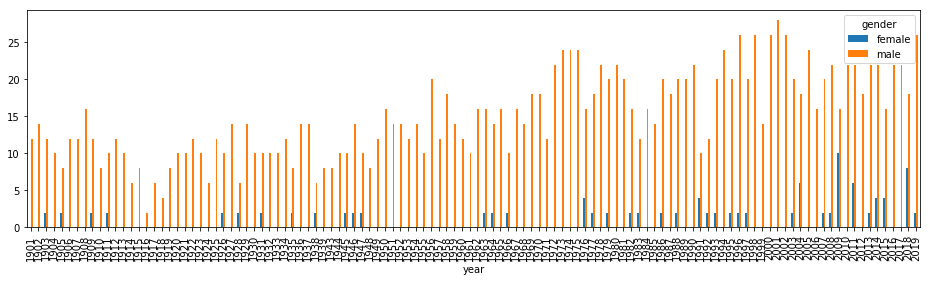

In [13]:
# check there has been any increase in female prize allocation in recent years using historical trend
by_year_gender = df.groupby(['year','gender'])
year_gen_sz = by_year_gender.size().unstack()
year_gen_sz.plot(kind='bar', figsize=(16,4))

In [14]:
# Reducing the number of x-axis labels
def thin_xticks(ax, tick_gap=10, rotation=45):
    """ Thin x-ticks and adjust rotation """
    # Gets the existing locations and labels of the x-ticks, currently one per bar.
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    # Sets the new tick locations and labels at an interval of tick_gap (default 10).
    # Rotates the labels for readability, by default on an upward diagonal.
    ax.xaxis.set_ticks(ticks[::tick_gap])
    ax.xaxis.set_ticklabels(ticklabels[::tick_gap],rotation=rotation)
    ax.figure.show()

In [15]:
by_year_gender = df.groupby(['year', 'gender'])
by_year_gender.size().unstack()

gender,female,male
year,,
1901,NaN,12.0
1902,NaN,14.0
1903,2.0,12.0
1904,NaN,10.0
1905,2.0,8.0
1906,NaN,12.0
1907,NaN,12.0
1908,NaN,16.0
1909,2.0,12.0


In [16]:
# reindex series to see any gaps (khoang trong) in the prize distribution
# Here we create a full-range index named year, covering all the Nobel Prize years.
new_index = pd.Index(np.arange(1901, 2015), name='year')
by_year_gender = df.groupby(['year','gender'])
# We replace our discontinuous index with the new continuous one.
year_gen_sz = by_year_gender.size().unstack().reindex(new_index)

Text(0.5, 0, 'Year')

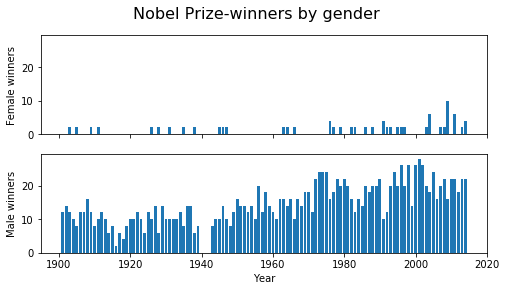

In [17]:
# dedicated male and female plots but stacked so as to allow easy comparison by using subplotting method
# Creates two axes, on a two (row) by one (column) grid.
# We’ll share the x- and y-axes, which will make comparisons between the two plots sensible.
fig, axes = plt.subplots(nrows=2, ncols=1,sharex=True, sharey=True)

ax_f = axes[0]
ax_m = axes[1]

fig.suptitle('Nobel Prize-winners by gender', fontsize=16)

# We provide the axis’s bar chart (bar) method with the continuous year index and the unstacked gender columns.
ax_f.bar(year_gen_sz.index, year_gen_sz.female)
ax_f.set_ylabel('Female winners')

ax_m.bar(year_gen_sz.index, year_gen_sz.male)
ax_m.set_ylabel('Male winners')

ax_m.set_xlabel('Year')

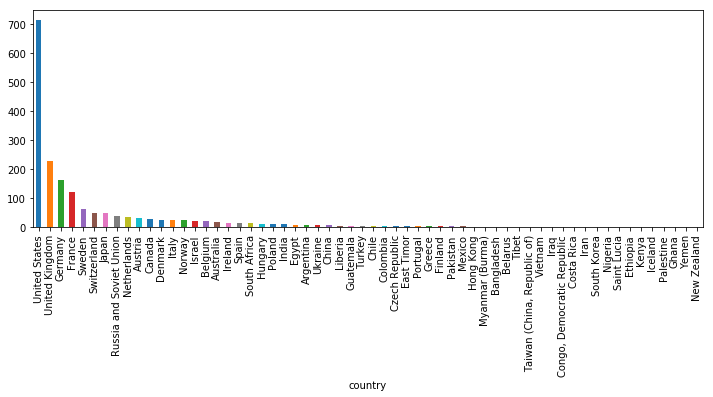

In [18]:
# National trends 
df.groupby('country').size().sort_values(ascending = False).plot(kind='bar', figsize=(12,4))

In [19]:
# Prize Winners per Capita
nat_group = df.groupby('country')
ngsz = nat_group.size()
ngsz.index

Index(['Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belarus', 'Belgium',
       'Canada', 'Chile', 'China', 'Colombia', 'Congo, Democratic Republic',
       'Costa Rica', 'Czech Republic', 'Denmark', 'East Timor', 'Egypt',
       'Ethiopia', 'Finland', 'France', 'Germany', 'Ghana', 'Greece',
       'Guatemala', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Iran', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Kenya', 'Liberia', 'Mexico',
       'Myanmar (Burma)', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway',
       'Pakistan', 'Palestine', 'Poland', 'Portugal',
       'Russia and Soviet Union', 'Saint Lucia', 'South Africa', 'South Korea',
       'Spain', 'Sweden', 'Switzerland', 'Taiwan (China, Republic of)',
       'Tibet', 'Turkey', 'Ukraine', 'United Kingdom', 'United States',
       'Vietnam', 'Yemen'],
      dtype='object', name='country')

In [20]:
# Now let’s load our country data into a DataFrame using our utility function mongo_to_dataframe
df_countries = mongo_to_dataframe('nobel_prize', 'country_data')
df_countries.ix[0] # selects the first row by position

C:\Users\XOANXOAN\Anaconda3\envs\nobel_prize\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


alpha2Code                                                       AF
alpha3Code                                                      AFG
altSpellings                                       [AF, Afġānistān]
area                                                         652230
borders                              [IRN, PAK, TKM, UZB, TJK, CHN]
callingCodes                                                   [93]
capital                                                       Kabul
currencies                                                    [AFN]
demonym                                                      Afghan
gini                                                           27.8
languages                                              [ps, uz, tk]
latlng                                                 [33.0, 65.0]
name                                                    Afghanistan
nativeName                                                افغانستان
numericCode                                     

In [21]:
df_countries

,alpha2Code,alpha3Code,altSpellings,area,borders,callingCodes,capital,currencies,demonym,gini,...,name,nativeName,numericCode,population,region,relevance,subregion,timezones,topLevelDomain,translations
0,AF,AFG,"[AF, Afġānistān]",652230.0,"[IRN, PAK, TKM, UZB, TJK, CHN]",[93],Kabul,[AFN],Afghan,27.8,...,Afghanistan,افغانستان,004,26023100,Asia,0,Southern Asia,[UTC+04:30],[.af],"{'de': 'Afghanistan', 'es': 'Afganistán', 'fr'..."
1,AX,ALA,"[AX, Aaland, Aland, Ahvenanmaa]",1580.0,[],[358],Mariehamn,[EUR],Ålandish,NaN,...,Åland Islands,Åland,248,28875,Europe,0,Northern Europe,[UTC+02:00],[.ax],"{'de': 'Åland', 'es': 'Alandia', 'fr': 'Åland'..."
2,AL,ALB,"[AL, Shqipëri, Shqipëria, Shqipnia]",28748.0,"[MNE, GRC, MKD, KOS]",[355],Tirana,[ALL],Albanian,34.5,...,Albania,Shqipëria,008,2893005,Europe,0,Southern Europe,[UTC+01:00],[.al],"{'de': 'Albanien', 'es': 'Albania', 'fr': 'Alb..."
3,DZ,DZA,"[DZ, Dzayer, Algérie]",2381741.0,"[TUN, LBY, NER, ESH, MRT, MLI, MAR]",[213],Algiers,[DZD],Algerian,35.3,...,Algeria,الجزائر,012,39500000,Africa,0,Northern Africa,[UTC+01:00],[.dz],"{'de': 'Algerien', 'es': 'Argelia', 'fr': 'Alg..."
4,AS,ASM,"[AS, Amerika Sāmoa, Amelika Sāmoa, Sāmoa Amelika]",199.0,[],[1684],Pago Pago,[USD],American Samoan,NaN,...,American Samoa,American Samoa,016,55519,Oceania,0.5,Polynesia,[UTC-11:00],[.as],"{'de': 'Amerikanisch-Samoa', 'es': 'Samoa Amer..."
5,AD,AND,"[AD, Principality of Andorra, Principat d'Ando...",468.0,"[FRA, ESP]",[376],Andorra la Vella,[EUR],Andorran,NaN,...,Andorra,Andorra,020,76949,Europe,0.5,Southern Europe,[UTC+01:00],[.ad],"{'de': 'Andorra', 'es': 'Andorra', 'fr': 'Ando..."
6,AO,AGO,"[AO, República de Angola, ʁɛpublika de an'ɡɔla]",1246700.0,"[COG, COD, ZMB, NAM]",[244],Luanda,[AOA],Angolan,58.6,...,Angola,Angola,024,24383301,Africa,0,Middle Africa,[UTC+01:00],[.ao],"{'de': 'Angola', 'es': 'Angola', 'fr': 'Angola..."
7,AI,AIA,[AI],91.0,[],[1264],The Valley,[XCD],Anguillian,NaN,...,Anguilla,Anguilla,660,13452,Americas,0.5,Caribbean,[UTC-04:00],[.ai],"{'de': 'Anguilla', 'es': 'Anguilla', 'fr': 'An..."
8,AQ,ATA,[],14000000.0,[],[],,"[AUD, GBP]",,NaN,...,Antarctica,Antarctica,010,1000,Polar,0,,"[UTC-03:00, UTC+03:00, UTC+05:00, UTC+06:00, U...",[.aq],"{'de': 'Antarktika', 'es': 'Antártida', 'fr': ..."
9,AG,ATG,[AG],442.0,[],[1268],Saint John's,[XCD],"Antiguan, Barbudan",NaN,...,Antigua and Barbuda,Antigua and Barbuda,028,86295,Americas,0.5,Caribbean,[UTC-04:00],[.ag],"{'de': 'Antigua und Barbuda', 'es': 'Antigua y..."


In [22]:
# If we set the index of our country dataset to its name column and add the ngsz national group-size Series
# which also has a country name index, the two will combine on the shared indices, giving our country data a new nobel_wins column. We can then use this new
# column to create a nobel_wins_per_capita by dividing it by population size:
#df_countries = df_countries.set_index('name')
df_countries['nobel_wins'] = ngsz
df_countries['nobel_wins_per_capita'] = df_countries.nobel_wins / df_countries.population

In [23]:
df_countries

,alpha2Code,alpha3Code,altSpellings,area,borders,callingCodes,capital,currencies,demonym,gini,...,numericCode,population,region,relevance,subregion,timezones,topLevelDomain,translations,nobel_wins,nobel_wins_per_capita
0,AF,AFG,"[AF, Afġānistān]",652230.0,"[IRN, PAK, TKM, UZB, TJK, CHN]",[93],Kabul,[AFN],Afghan,27.8,...,004,26023100,Asia,0,Southern Asia,[UTC+04:30],[.af],"{'de': 'Afghanistan', 'es': 'Afganistán', 'fr'...",NaN,NaN
1,AX,ALA,"[AX, Aaland, Aland, Ahvenanmaa]",1580.0,[],[358],Mariehamn,[EUR],Ålandish,NaN,...,248,28875,Europe,0,Northern Europe,[UTC+02:00],[.ax],"{'de': 'Åland', 'es': 'Alandia', 'fr': 'Åland'...",NaN,NaN
2,AL,ALB,"[AL, Shqipëri, Shqipëria, Shqipnia]",28748.0,"[MNE, GRC, MKD, KOS]",[355],Tirana,[ALL],Albanian,34.5,...,008,2893005,Europe,0,Southern Europe,[UTC+01:00],[.al],"{'de': 'Albanien', 'es': 'Albania', 'fr': 'Alb...",NaN,NaN
3,DZ,DZA,"[DZ, Dzayer, Algérie]",2381741.0,"[TUN, LBY, NER, ESH, MRT, MLI, MAR]",[213],Algiers,[DZD],Algerian,35.3,...,012,39500000,Africa,0,Northern Africa,[UTC+01:00],[.dz],"{'de': 'Algerien', 'es': 'Argelia', 'fr': 'Alg...",NaN,NaN
4,AS,ASM,"[AS, Amerika Sāmoa, Amelika Sāmoa, Sāmoa Amelika]",199.0,[],[1684],Pago Pago,[USD],American Samoan,NaN,...,016,55519,Oceania,0.5,Polynesia,[UTC-11:00],[.as],"{'de': 'Amerikanisch-Samoa', 'es': 'Samoa Amer...",NaN,NaN
5,AD,AND,"[AD, Principality of Andorra, Principat d'Ando...",468.0,"[FRA, ESP]",[376],Andorra la Vella,[EUR],Andorran,NaN,...,020,76949,Europe,0.5,Southern Europe,[UTC+01:00],[.ad],"{'de': 'Andorra', 'es': 'Andorra', 'fr': 'Ando...",NaN,NaN
6,AO,AGO,"[AO, República de Angola, ʁɛpublika de an'ɡɔla]",1246700.0,"[COG, COD, ZMB, NAM]",[244],Luanda,[AOA],Angolan,58.6,...,024,24383301,Africa,0,Middle Africa,[UTC+01:00],[.ao],"{'de': 'Angola', 'es': 'Angola', 'fr': 'Angola...",NaN,NaN
7,AI,AIA,[AI],91.0,[],[1264],The Valley,[XCD],Anguillian,NaN,...,660,13452,Americas,0.5,Caribbean,[UTC-04:00],[.ai],"{'de': 'Anguilla', 'es': 'Anguilla', 'fr': 'An...",NaN,NaN
8,AQ,ATA,[],14000000.0,[],[],,"[AUD, GBP]",,NaN,...,010,1000,Polar,0,,"[UTC-03:00, UTC+03:00, UTC+05:00, UTC+06:00, U...",[.aq],"{'de': 'Antarktika', 'es': 'Antártida', 'fr': ...",NaN,NaN
9,AG,ATG,[AG],442.0,[],[1268],Saint John's,[XCD],"Antiguan, Barbudan",NaN,...,028,86295,Americas,0.5,Caribbean,[UTC-04:00],[.ag],"{'de': 'Antigua und Barbuda', 'es': 'Antigua y...",NaN,NaN


In [24]:
df_countries[df_countries.nobel_wins > 2].sort_values(by='nobel_wins_per_capita', ascending=False)\
.nobel_wins_per_capita.plot(kind='bar')

TypeError: Empty 'DataFrame': no numeric data to plot

In [25]:
df_countries

,alpha2Code,alpha3Code,altSpellings,area,borders,callingCodes,capital,currencies,demonym,gini,...,numericCode,population,region,relevance,subregion,timezones,topLevelDomain,translations,nobel_wins,nobel_wins_per_capita
0,AF,AFG,"[AF, Afġānistān]",652230.0,"[IRN, PAK, TKM, UZB, TJK, CHN]",[93],Kabul,[AFN],Afghan,27.8,...,004,26023100,Asia,0,Southern Asia,[UTC+04:30],[.af],"{'de': 'Afghanistan', 'es': 'Afganistán', 'fr'...",NaN,NaN
1,AX,ALA,"[AX, Aaland, Aland, Ahvenanmaa]",1580.0,[],[358],Mariehamn,[EUR],Ålandish,NaN,...,248,28875,Europe,0,Northern Europe,[UTC+02:00],[.ax],"{'de': 'Åland', 'es': 'Alandia', 'fr': 'Åland'...",NaN,NaN
2,AL,ALB,"[AL, Shqipëri, Shqipëria, Shqipnia]",28748.0,"[MNE, GRC, MKD, KOS]",[355],Tirana,[ALL],Albanian,34.5,...,008,2893005,Europe,0,Southern Europe,[UTC+01:00],[.al],"{'de': 'Albanien', 'es': 'Albania', 'fr': 'Alb...",NaN,NaN
3,DZ,DZA,"[DZ, Dzayer, Algérie]",2381741.0,"[TUN, LBY, NER, ESH, MRT, MLI, MAR]",[213],Algiers,[DZD],Algerian,35.3,...,012,39500000,Africa,0,Northern Africa,[UTC+01:00],[.dz],"{'de': 'Algerien', 'es': 'Argelia', 'fr': 'Alg...",NaN,NaN
4,AS,ASM,"[AS, Amerika Sāmoa, Amelika Sāmoa, Sāmoa Amelika]",199.0,[],[1684],Pago Pago,[USD],American Samoan,NaN,...,016,55519,Oceania,0.5,Polynesia,[UTC-11:00],[.as],"{'de': 'Amerikanisch-Samoa', 'es': 'Samoa Amer...",NaN,NaN
5,AD,AND,"[AD, Principality of Andorra, Principat d'Ando...",468.0,"[FRA, ESP]",[376],Andorra la Vella,[EUR],Andorran,NaN,...,020,76949,Europe,0.5,Southern Europe,[UTC+01:00],[.ad],"{'de': 'Andorra', 'es': 'Andorra', 'fr': 'Ando...",NaN,NaN
6,AO,AGO,"[AO, República de Angola, ʁɛpublika de an'ɡɔla]",1246700.0,"[COG, COD, ZMB, NAM]",[244],Luanda,[AOA],Angolan,58.6,...,024,24383301,Africa,0,Middle Africa,[UTC+01:00],[.ao],"{'de': 'Angola', 'es': 'Angola', 'fr': 'Angola...",NaN,NaN
7,AI,AIA,[AI],91.0,[],[1264],The Valley,[XCD],Anguillian,NaN,...,660,13452,Americas,0.5,Caribbean,[UTC-04:00],[.ai],"{'de': 'Anguilla', 'es': 'Anguilla', 'fr': 'An...",NaN,NaN
8,AQ,ATA,[],14000000.0,[],[],,"[AUD, GBP]",,NaN,...,010,1000,Polar,0,,"[UTC-03:00, UTC+03:00, UTC+05:00, UTC+06:00, U...",[.aq],"{'de': 'Antarktika', 'es': 'Antártida', 'fr': ...",NaN,NaN
9,AG,ATG,[AG],442.0,[],[1268],Saint John's,[XCD],"Antiguan, Barbudan",NaN,...,028,86295,Americas,0.5,Caribbean,[UTC-04:00],[.ag],"{'de': 'Antigua und Barbuda', 'es': 'Antigua y...",NaN,NaN


In [26]:
# Prizes by Category
nat_cat_sz = df.groupby(['country', 'category']).size().unstack()
nat_cat_sz

category,Chemistry,Economics,Literature,Peace,Physics,Physiology or Medicine
country,,,,,,
Argentina,2.0,NaN,NaN,4.0,NaN,2.0
Australia,NaN,NaN,2.0,NaN,3.0,14.0
Austria,5.0,1.0,4.0,4.0,6.0,10.0
Bangladesh,NaN,NaN,NaN,2.0,NaN,NaN
Belarus,NaN,NaN,2.0,NaN,NaN,NaN
Belgium,2.0,NaN,2.0,6.0,2.0,8.0
Canada,5.0,2.0,2.0,2.0,10.0,6.0
Chile,NaN,NaN,4.0,NaN,NaN,NaN
China,NaN,NaN,2.0,2.0,NaN,2.0


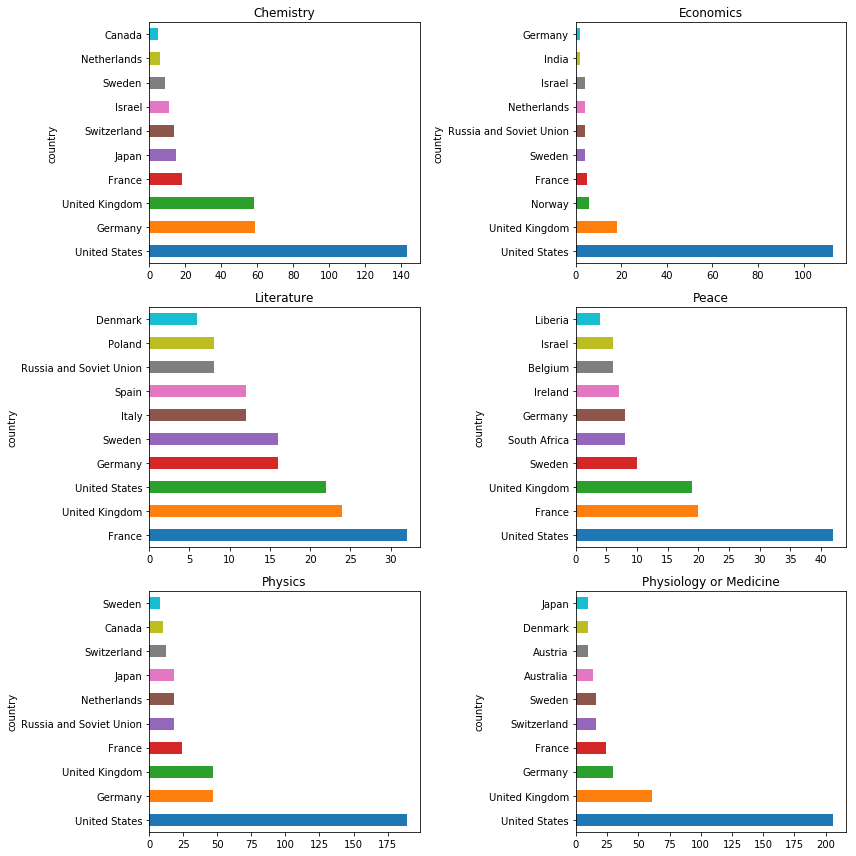

In [27]:
# use the nat_cat_sz DataFrame to produce subplots for the six Nobel Prize categories:
COL_NUM = 2
ROW_NUM = 3

fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

# iteritems returns an iterator for the DataFrames columns in form of (column_label, column) tuples.
for i, (label, col) in enumerate(nat_cat_sz.iteritems()):
    ax = axes[i//COL_NUM, i%COL_NUM]
    # order orders the column’s Series by first making a copy. It is the equivalent of sort(inplace=False).
    col = col.sort_values(ascending = False)[:10]
    col.plot(kind='barh', ax=ax)
    ax.set_title(label)
   
plt.tight_layout()

In [28]:
# Historical Trends in Prize Distribution
# let’s increase the default font size to 20 points to make the plot labels more legible:
plt.rcParams['font.size'] = 20

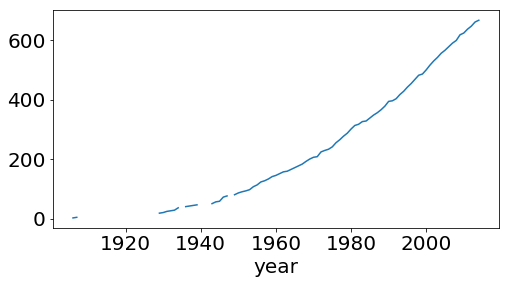

In [29]:
# We’re going to be looking at prize distribution by year and country,so we’ll need a new unstacked DataFrame based on these two columns.
new_index = pd.Index(np.arange(1901, 2015), name='year')
by_year_nat_sz = df.groupby(['year', 'country']).size().unstack().reindex(new_index)
by_year_nat_sz['United States'].cumsum().plot()

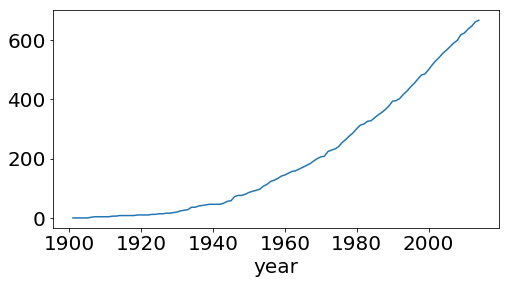

In [30]:
# The gaps in the line plot are where the fields are NaN, years when the
# US won no prizes. The cumsum algorithm returns NaN here. Let’s fill
# those in with a zero to remove the gaps:
by_year_nat_sz['United States'].fillna(0).cumsum().plot()

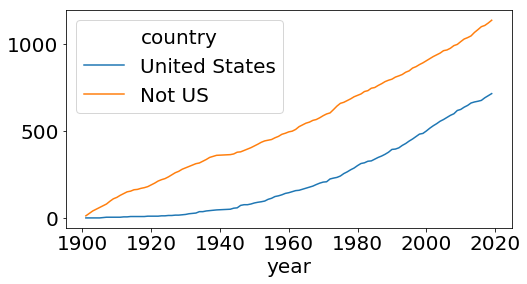

In [31]:
# Let’s compare the US prize rate with that of the rest of the world:
by_year_nat_sz = df.groupby(['year', 'country']).size().unstack().fillna(0)
# Gets the list of country column names and removes United States.
not_US = by_year_nat_sz.columns.tolist()
not_US.remove('United States')

# Uses our list of non-US country names to create a 'Not_US' column, the sum of all the prizes for countries in the not_US list.
by_year_nat_sz['Not US'] = by_year_nat_sz[not_US].sum(axis=1)
ax = by_year_nat_sz[['United States', 'Not US']].cumsum().plot()

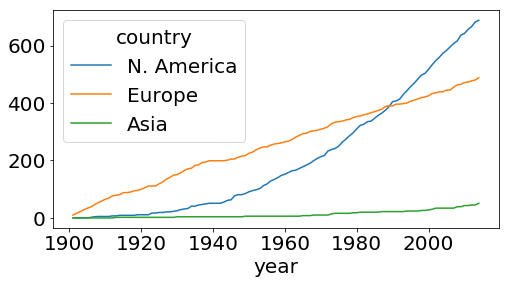

In [33]:
# Where the 'Not_US' haul shows a steady increase over the years of the prize, the US shows a rapid increase around the end of World
# War II. Let’s investigate that further, looking at regional differences.We’ll focus on the two or three largest winners for North America,
# Europe, and Asia:

by_year_nat_sz = df.groupby(['year', 'country']).size().unstack().reindex(new_index).fillna(0)

# Our continental country list created by selecting the biggest two or three winners in the three continents compared.
regions = [
    {'label':'N. America','countries':['United States', 'Canada']},
    {'label':'Europe','countries':['United Kingdom', 'Germany', 'France']},
    {'label':'Asia','countries':['Japan', 'Vietnam', 'India']}]

# Creates a new column with a region label for each dict in the regions list, summing its countries members.
for region in regions:
    by_year_nat_sz[region['label']] =by_year_nat_sz[region['countries']].sum(axis=1)

#Plots the cumulative sum of all the new region columns.    
by_year_nat_sz[[r['label'] for r in regions]].cumsum().plot()

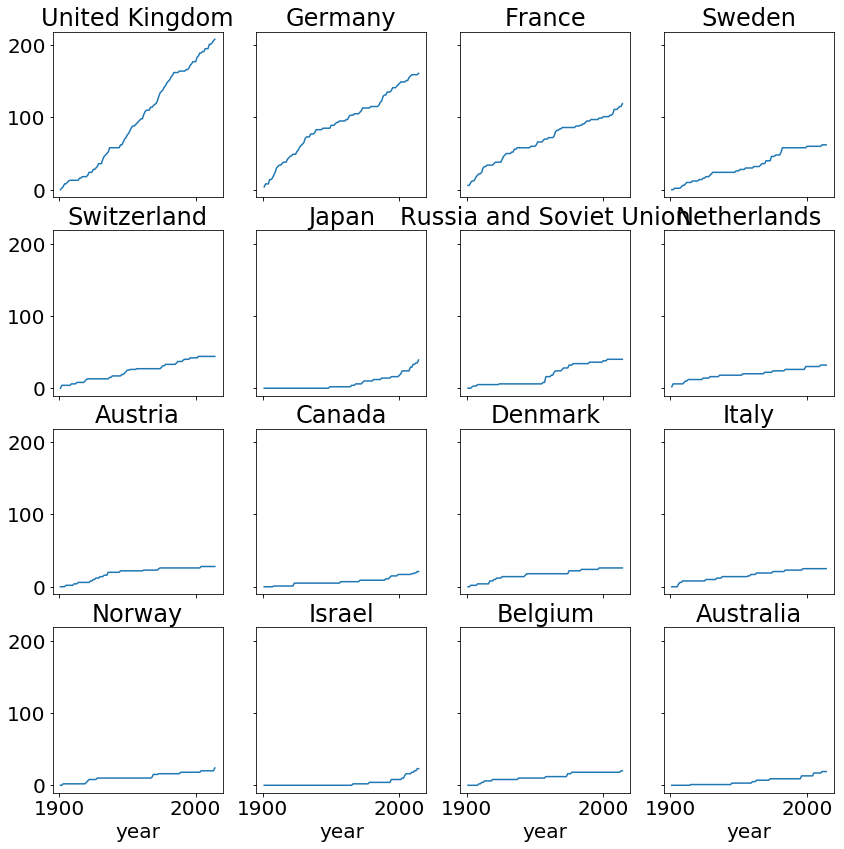

In [39]:
# Let’s improve the resolution of the previous national plots by summarizing the prize rates for the 16 biggest winners, excluding the
# outlying United States:

COL_NUM = 4
ROW_NUM = 4

by_nat_sz = df.groupby('country').size()
#Sorts our country groups from highest to lowest win hauls.
by_nat_sz.sort_values(ascending=False,inplace=True)

# Gets a 4×4 grid of axes with shared x- and y-axes for normalized comparison.
fig, axes = plt.subplots(COL_NUM, ROW_NUM,\
sharex=True, sharey=True,
figsize=(14,14))

#Enumerates over the sorted index from second row (1), excluding the US (0).
for i, nat in enumerate(by_nat_sz.index[1:17]):
    ax = axes[i//COL_NUM, i%ROW_NUM]
    #Selects the nat country name column and plots its cumulative sum of prizes on the grid axis ax.
    by_year_nat_sz[nat].cumsum().plot(ax=ax)
    ax.set_title(nat)

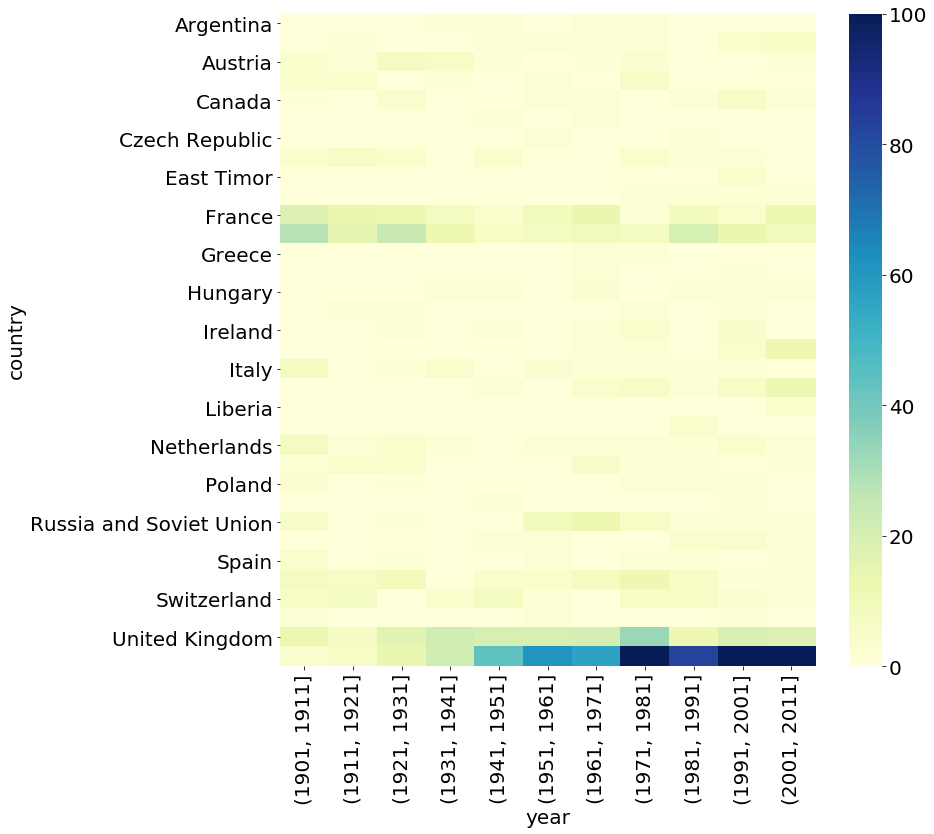

In [58]:
# Another good way to summarize national prize rates over time is by
# using a heatmap and dividing the totals by decade. This division is
# also known as binning, as it creates bins of data.

#Gets our bin ranges for the decades from 1901 (1901, 1911,1921...).
bins = np.arange(df.year.min(), df.year.max(), 10)

#Cuts our Nobel Prize years into decades using the bins ranges with precision set to 0, to give integer years.
by_year_nat_binned = df.groupby(['country',pd.cut(df.year, bins, precision=0)]).size().unstack().fillna(0)
plt.figure(figsize=(12, 12))

# Before heatmapping, we filter for those countries with over two Nobel Prizes.
sns.heatmap(by_year_nat_binned[by_year_nat_binned.sum(axis=1) > 2],vmin=0, vmax=100, cmap="YlGnBu")

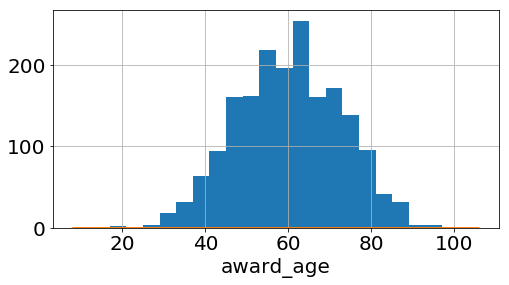

In [61]:
# Now that we’ve investigated the Nobel Prize nations, let’s turn our attention to the individual winners.
# Age and Life Expectancy of Winners
#Age at Time of Award
df['award_age'].hist(bins=20)
sns.distplot(df['award_age'])

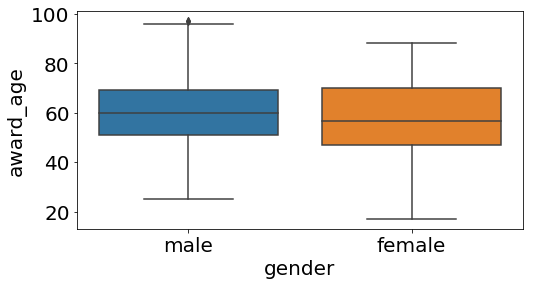

In [62]:
sns.boxplot(df.gender, df.award_age)

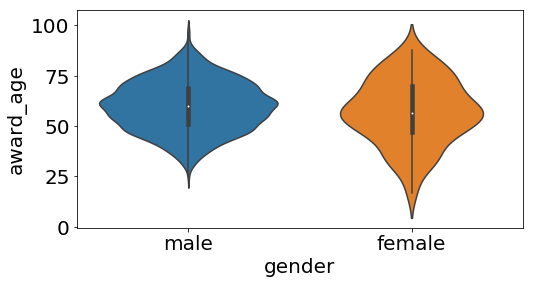

In [63]:
sns.violinplot(df.gender, df.award_age)

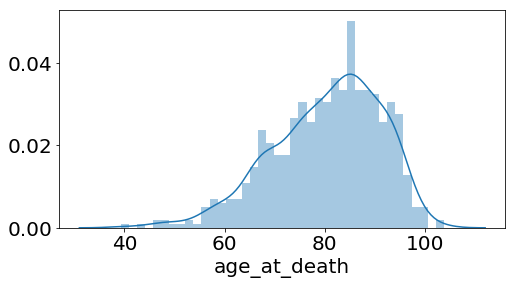

In [64]:
# Life Expectancy of Winners
df['age_at_death'] = (df.date_of_death - df.date_of_birth).dt.days/365
age_at_death = df[df.age_at_death.notnull()].age_at_death
sns.distplot(age_at_death, bins=40)

In [65]:
# shows some centenarians among the prize winners.Let’s find them:
df[df.age_at_death > 100][['name', 'category', 'year']]

,name,category,year
206,Ronald Coase,Economics,1991
591,Rita Levi-Montalcini,Physiology or Medicine,1986
940,Rita Levi-Montalcini,Physiology or Medicine,1986
1327,Ronald Coase,Economics,1991


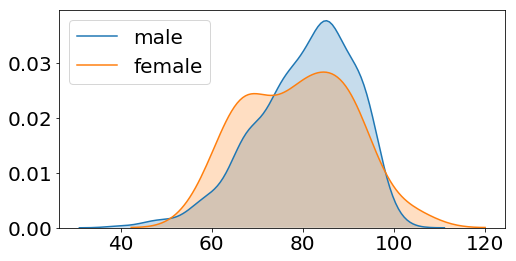

In [66]:
# let’s superimpose a couple of KDEs to show differences in mortality for male and female recipients:
df2 = df[df.age_at_death.notnull()]
sns.kdeplot(df2[df2.gender == 'male'].age_at_death, shade=True, label='male')

sns.kdeplot(df2[df2.gender == 'female'].age_at_death, shade=True, label='female')
plt.legend()

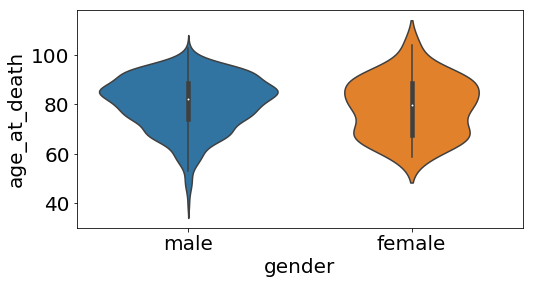

In [67]:
sns.violinplot(df.gender, age_at_death)

C:\Users\XOANXOAN\Anaconda3\envs\nobel_prize\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


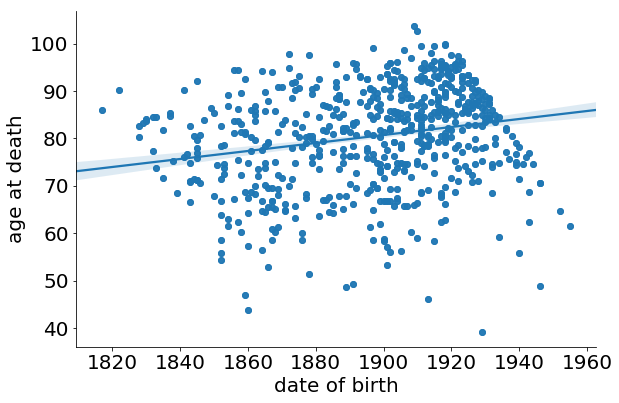

In [68]:
# Increasing Life Expectancies over Time
# Let’s do a little historical demographic analysis by seeing if there’s a correlation between the date of birth of our Nobel Prize winners and their life expectancy.

#Creates a temporary DataFrame, removing all the rows with no 'age_at_death' field.
df_temp=df[df.age_at_death.notnull()]

#Creates a new DataFrame with only the two columns of interest from the refined df_temp. We grab only the year from the date_of_birth, using its dt accessor.
data = pd.DataFrame({'age at death':df_temp.age_at_death,'date of birth':df_temp.date_of_birth.dt.year})
sns.lmplot('date of birth', 'age at death', data,size=6, aspect=1.5)